## Importing datasets and packages

We will begin with importing all relevant datasets and packages needed in order to create our model.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV, mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna

In [3]:
#load smote_train_data for training data and transformed_data for evaluation
smote_train_data_folder_path = '/Users/joanwong/Desktop/cs3244/finalised_datasets/smote_train_data'
transformed_data_folder_path = '/Users/joanwong/Desktop/cs3244/finalised_datasets/transformed_data'

smote_files = ['smote_fold_1.csv', 'smote_fold_2.csv', 'smote_fold_3.csv', 'smote_fold_4.csv', 'smote_fold_5.csv']
non_smote_files = ['fold_1.csv', 'fold_2.csv','fold_3.csv', 'fold_4.csv', 'fold_5.csv']


testing_data = pd.read_csv('/Users/joanwong/Desktop/cs3244/finalised_datasets/transformed_data/test_set.csv')
testing_data = testing_data.drop(columns = ['client_id', 'creation_date'])


# Feature Selection

##  Recursive Feature Elimination with Cross-Validation (RFECV)

In [6]:
# Custom cross-validation using RFECV
feature_rankings = pd.DataFrame()  # Track feature rankings across all folds

for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Step 1: Feature Selection using RFECV
    print(f"\nFold {i+1}: Performing RFECV for feature selection...")
    model = DecisionTreeClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # 3-fold cross-validation within each fold
    rfecv = RFECV(estimator=model, step=2, cv=cv, scoring='f1', n_jobs=-1)
    rfecv.fit(X_train, y_train)

    # Store feature rankings
    ranking = pd.Series(rfecv.ranking_, index=features)
    feature_rankings = pd.concat([feature_rankings, ranking], axis=1)

    # Train model with selected features (RFECV)
    selected_features_rfecv = X_train.columns[rfecv.support_]
    X_train_rfecv = X_train[selected_features_rfecv]
    X_test_rfecv = X_test[selected_features_rfecv]
    model.fit(X_train_rfecv, y_train)
    y_pred_rfecv = model.predict(X_test_rfecv)
    f1_rfecv = f1_score(y_test, y_pred_rfecv)
    print(f"RFECV Fold {i+1}: F1 Score = {f1_rfecv:.4f}")



Fold 1: Performing RFECV for feature selection...
RFECV Fold 1: F1 Score = 0.0000

Fold 2: Performing RFECV for feature selection...
RFECV Fold 2: F1 Score = 0.2187

Fold 3: Performing RFECV for feature selection...
RFECV Fold 3: F1 Score = 0.0017

Fold 4: Performing RFECV for feature selection...
RFECV Fold 4: F1 Score = 0.2466

Fold 5: Performing RFECV for feature selection...
RFECV Fold 5: F1 Score = 0.2501


### Selecting an Optimal Number of Features
Choosing the number of features based on when the graph of Number of Features Used vs Cross Validation (F1 Score) reaches a plateau.
Ranking of features is aggregated across the 5 folds.

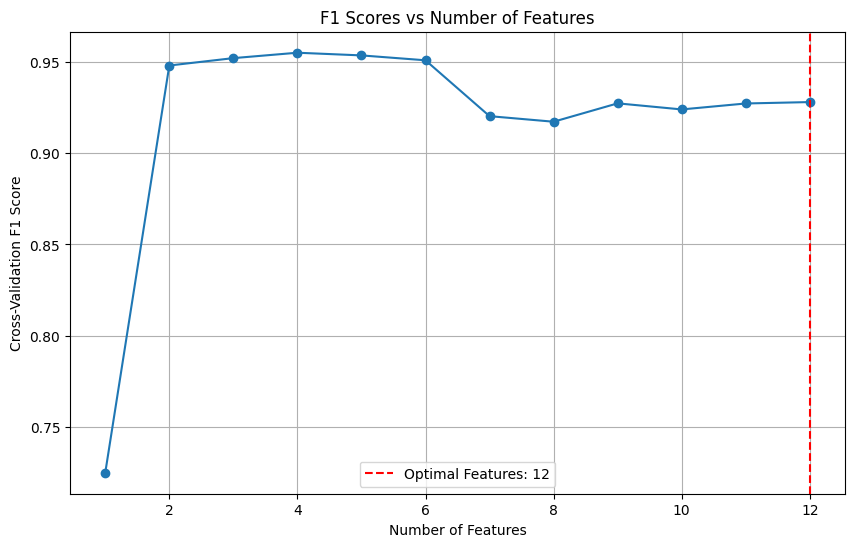

Optimal number of features where change is sufficiently close to 0: 12
Selected features based on optimal number: ['meter_number_count', 'reading_remark_8', 'meter_code_count', 'months_number_max', 'district_63', 'district_69', 'old_index_median', 'region_101', 'district_62', 'consumption_level_2_max', 'meter_status_1.0', 'old_index_mean']


In [58]:
# Aggregate feature rankings across all folds
avg_rankings = feature_rankings.mean(axis=1)
sorted_features = avg_rankings.sort_values().index  # Features sorted by average rank

# Code for plotting F1 scores vs number of features and determining optimal count
f1_scores = []
threshold = 0.001  # Set a threshold for what counts as "sufficiently close to 0"
last_f1_score = None
optimal_num_features = None

# Loop through increasing numbers of features
for i in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:i]
    X_train_selected = X_train[selected_features]
    
    # Perform cross-validation with the selected features
    model = DecisionTreeClassifier(random_state=42)
    f1 = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='f1').mean()
    f1_scores.append(f1)

    # Check if the difference is sufficiently small
    if last_f1_score is not None:
        difference = abs(f1 - last_f1_score)
        if difference <= threshold:
            optimal_num_features = i
            break

    last_f1_score = f1

# Plot the F1 scores vs number of features (show the entire range)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation F1 Score')
plt.title('F1 Scores vs Number of Features')
plt.grid()

# Mark the optimal number of features with a red dotted line
if optimal_num_features is not None:
    plt.axvline(x=optimal_num_features, color='r', linestyle='--', label=f'Optimal Features: {optimal_num_features}')
plt.legend()
plt.show()

# Print the optimal number of features and the selected features
if optimal_num_features is not None:
    print(f"Optimal number of features where change is sufficiently close to 0: {optimal_num_features}")
    selected_features_final = sorted_features[:optimal_num_features]
    print(f"Selected features based on optimal number: {list(selected_features_final)}")
else:
    print("No plateau detected within the set threshold.")

selected_features_rfecv = list(selected_features_final)

## Mutual Information

Fold 1: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 1: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


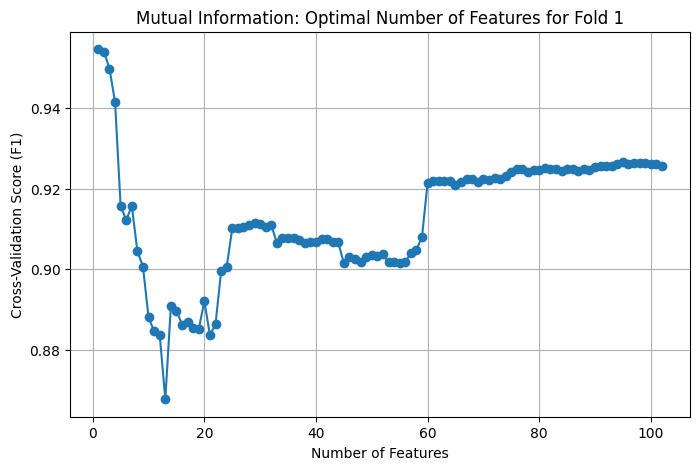

Mutual Information Fold 1: F1 Score = 0.0099
Fold 2: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 2: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


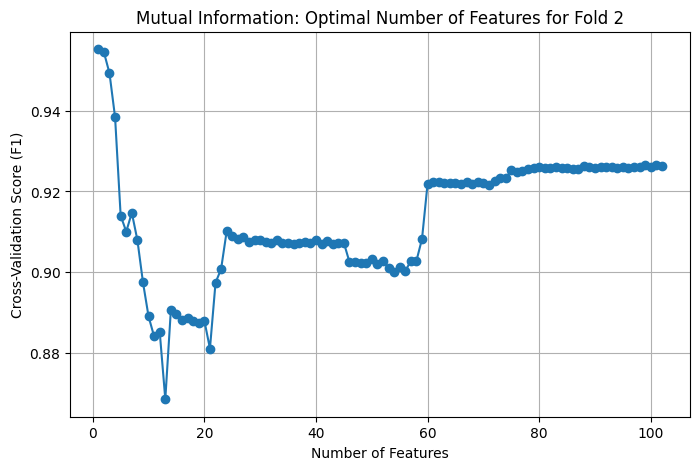

Mutual Information Fold 2: F1 Score = 0.0066
Fold 3: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 3: 1
Selected features using Mutual Information: Index(['no_of_invoices'], dtype='object')


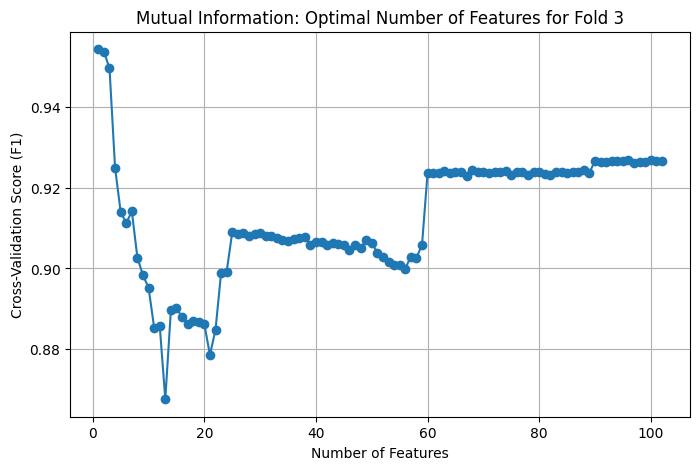

Mutual Information Fold 3: F1 Score = 0.0017
Fold 4: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 4: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


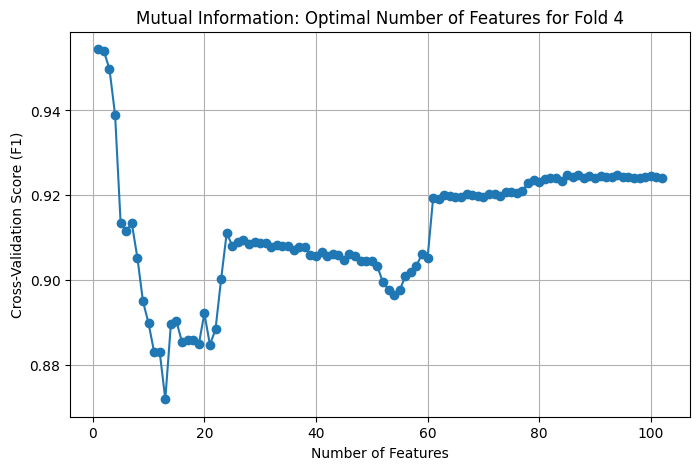

Mutual Information Fold 4: F1 Score = 0.0131
Fold 5: Performing Mutual Information for feature selection...
Optimal number of features based on cross-validation for Fold 5: 1
Selected features using Mutual Information: Index(['is_index_discrepancy_False'], dtype='object')


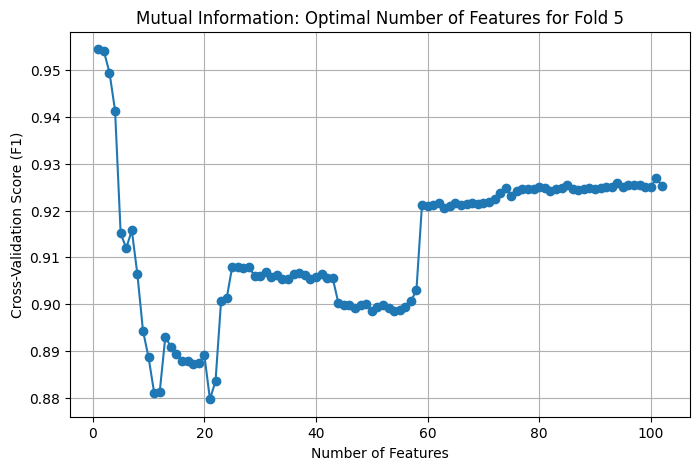

Mutual Information Fold 5: F1 Score = 0.0033


In [16]:
# Custom cross-validation using Mutual Information
feature_counts_mi = []  # Track number of features selected for each fold
selected_features_mi_all_folds = []  # Track selected features for each fold
avg_mutual_info = pd.DataFrame()  # Track feature importance values across all folds

for i in range(len(smote_files)):
    # Define training and testing sets
    train_smote_files = [file for j, file in enumerate(smote_files) if j != i]  # All folds except the i-th for training
    test_non_smote_file = non_smote_files[i]  # The corresponding non-smoted fold for testing

    # Load training data
    train_dataframes = []
    for file in train_smote_files:
        file_path = os.path.join(smote_train_data_folder_path, file)
        df = pd.read_csv(file_path)
        train_dataframes.append(df)

    # Concatenate training data
    train_data = pd.concat(train_dataframes, ignore_index=True)

    # Load testing data
    test_file_path = os.path.join(smote_train_data_folder_path, test_non_smote_file)
    test_data = pd.read_csv(test_file_path)

    # Split features and target
    features = train_data.columns.drop('fraud_status')
    X_train = train_data[features]
    y_train = train_data['fraud_status']
    X_test = test_data[features]
    y_test = test_data['fraud_status']

    # Step 1: Feature Selection using Mutual Information
    print(f"Fold {i+1}: Performing Mutual Information for feature selection...")
    mutual_info = mutual_info_classif(X_train, y_train)
    mutual_info_series = pd.Series(mutual_info, index=X_train.columns).sort_values(ascending=False)
    avg_mutual_info = pd.concat([avg_mutual_info, mutual_info_series], axis=1)  # Store feature importance

    scores = []

    # Determine optimal number of features using cross-validation
    best_score = 0
    optimal_k = 0
    for k in range(1, len(mutual_info_series) + 1):
        selected_features = mutual_info_series.head(k).index
        X_train_selected = X_train[selected_features]
        score = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='f1').mean()
        scores.append(score)

        if score > best_score:
            best_score = score
            optimal_k = k

    print(f"Optimal number of features based on cross-validation for Fold {i + 1}: {optimal_k}")
    selected_features_mi_optimal = mutual_info_series.head(optimal_k).index
    print("Selected features using Mutual Information:", selected_features_mi_optimal)
    feature_counts_mi.append(len(selected_features_mi_optimal))
    selected_features_mi_all_folds.append(selected_features_mi_optimal)

    # Plot the cross-validation scores vs. number of features
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(mutual_info_series) + 1), scores, marker='o')
    plt.xlabel('Number of Features')
    plt.ylabel('Cross-Validation Score (F1)')
    plt.title(f'Mutual Information: Optimal Number of Features for Fold {i + 1}')
    plt.grid(True)
    plt.show()

    X_train_mi = X_train[selected_features_mi_optimal]
    X_test_mi = X_test[selected_features_mi_optimal]

    # Step 2: Train model with selected features (Mutual Information)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train_mi, y_train)
    y_pred_mi = model.predict(X_test_mi)
    f1_mi = f1_score(y_test, y_pred_mi)
    print(f"Mutual Information Fold {i+1}: F1 Score = {f1_mi:.4f}")



### Selecting an Optimal Number of Features
Choosing the number of features based on when the graph of Number of Features Used vs Cross Validation (F1 Score) reaches a plateau.
Ranking of features is aggregated across the 5 folds.


Aggregated Feature Importance (Mean Mutual Information Scores):
is_index_discrepancy_False     0.549154
no_of_invoices                 0.548744
meter_type_0                   0.535054
reading_remark_6               0.530267
time_since_last_invoice_max    0.529135
                                 ...   
consumption_level_4_min        0.000286
meter_coefficient_20           0.000182
meter_status_3.0               0.000168
meter_coefficient_30           0.000052
meter_coefficient_50           0.000011
Length: 102, dtype: float64


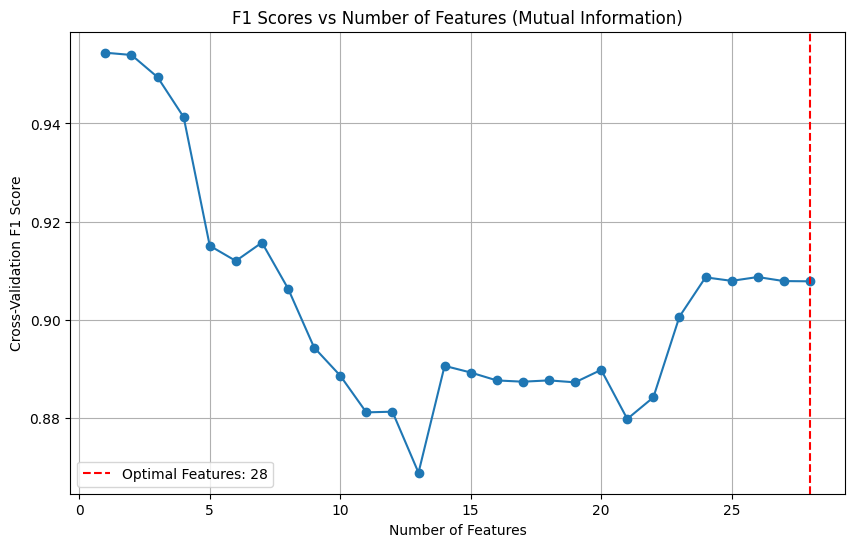


Optimal number of features where change is sufficiently close to 0: 28
Selected features based on optimal number: ['is_index_discrepancy_False', 'no_of_invoices', 'meter_type_0', 'reading_remark_6', 'time_since_last_invoice_max', 'reading_remark_9', 'reading_remark_8', 'time_since_last_invoice_min', 'time_since_last_invoice_median', 'consumption_level_1_max', 'total_consumption_max', 'diff_in_index_max', 'consumption_level_2_max', 'months_number_max', 'meter_type_1', 'consumption_level_1_min', 'consumption_level_2_sum', 'total_consumption_min', 'diff_in_index_min', 'meter_number_count', 'consumption_level_3_max', 'meter_status_1.0', 'meter_code_count', 'months_number_min', 'consumption_level_3_sum', 'time_since_last_invoice_mean', 'consumption_level_2_mean', 'consumption_level_1_sum']


In [59]:
# Aggregated Feature Importance
avg_mutual_info_mean = avg_mutual_info.mean(axis=1).sort_values(ascending=False)  # Mean importance across all folds
print("\nAggregated Feature Importance (Mean Mutual Information Scores):")
print(avg_mutual_info_mean)

# Determine Optimal Features across all folds based on average mutual information
f1_scores = []
threshold = 0.0001  # Set a threshold for what counts as "sufficiently close to 0"
last_f1_score = None
optimal_num_features = None

# Loop through increasing numbers of features based on average mutual information ranking
for i in range(1, len(avg_mutual_info_mean) + 1):
    selected_features = avg_mutual_info_mean.head(i).index
    X_train_selected = X_train[selected_features]
    
    # Perform cross-validation with the selected features
    model = DecisionTreeClassifier(random_state=42)
    f1 = cross_val_score(model, X_train_selected, y_train, cv=3, scoring='f1').mean()
    f1_scores.append(f1)

    # Check if the difference is sufficiently small
    if last_f1_score is not None:
        difference = abs(f1 - last_f1_score)
        if difference <= threshold:
            optimal_num_features = i
            break

    last_f1_score = f1

# Plot the F1 scores vs number of features (show the entire range)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation F1 Score')
plt.title('F1 Scores vs Number of Features (Mutual Information)')
plt.grid()

# Mark the optimal number of features with a red dotted line
if optimal_num_features is not None:
    plt.axvline(x=optimal_num_features, color='r', linestyle='--', label=f'Optimal Features: {optimal_num_features}')
plt.legend()
plt.show()

# Print the optimal number of features and the selected features
if optimal_num_features is not None:
    print(f"\nOptimal number of features where change is sufficiently close to 0: {optimal_num_features}")
    selected_features_final = avg_mutual_info_mean.head(optimal_num_features).index
    print(f"Selected features based on optimal number: {list(selected_features_final)}")
else:
    print("\nNo plateau detected within the set threshold.")

selected_features_mi = list(selected_features_final)

# Methods Selection

In [66]:
# Load the complete training and testing datasets
train_data = pd.concat([pd.read_csv(os.path.join(smote_train_data_folder_path, file)) for file in smote_files], ignore_index=True)
test_data = pd.read_csv(os.path.join(transformed_data_folder_path, 'test_set.csv'))

# Split features and target for training and testing
features = train_data.columns.drop('fraud_status')
X_train_full = train_data[features]
y_train_full = train_data['fraud_status']
X_test_full = test_data[features]
y_test_full = test_data['fraud_status']


# Create a sample with a stratified split to maintain class balance
sample_fraction = 0.4
X_sample, X_sample_test, y_sample, y_sample_test = train_test_split(X_train_full, y_train_full, test_size=(1 - sample_fraction), stratify=y_train_full, random_state=42)

# Choosing Between Feature Selection Methods

In [68]:
# Step 7.1: Use Optuna to choose the best feature selection method (RFECV or Mutual Information)
def feature_selection_objective(trial):
    feature_method = trial.suggest_categorical('feature_method', ['RFECV', 'Mutual Information'])
    
    # Use the sample dataset for training and testing
    if feature_method == 'RFECV':
        features = selected_features_rfecv
    else:
        features = selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Train and evaluate model (e.g., DecisionTreeClassifier for consistency)
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    f1 = f1_score(y_test_final, y_pred)

    return f1

# Run Optuna to find the best feature selection method
feature_study = optuna.create_study(direction='maximize')
feature_study.optimize(feature_selection_objective, n_trials=30)

best_feature_method = feature_study.best_trial.params['feature_method']
print("Best feature selection method:", best_feature_method)
print("Best F1 score:", feature_study.best_value)

[I 2024-11-30 11:11:36,526] A new study created in memory with name: no-name-2ed7cfdf-ee2c-44a8-b37e-2bec89e4c0b0
[I 2024-11-30 11:11:37,181] Trial 0 finished with value: 0.934376597972452 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.934376597972452.
[I 2024-11-30 11:11:37,773] Trial 1 finished with value: 0.934376597972452 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.934376597972452.
[I 2024-11-30 11:11:38,347] Trial 2 finished with value: 0.934376597972452 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.934376597972452.
[I 2024-11-30 11:11:38,914] Trial 3 finished with value: 0.934376597972452 and parameters: {'feature_method': 'RFECV'}. Best is trial 0 with value: 0.934376597972452.
[I 2024-11-30 11:11:39,736] Trial 4 finished with value: 0.9542359192348565 and parameters: {'feature_method': 'Mutual Information'}. Best is trial 4 with value: 0.9542359192348565.
[I 2024-11-30 11:11:40,311] Trial 5 

Best feature selection method: Mutual Information
Best F1 score: 0.9542359192348565


# Choosing Best Ensemble Model

In [62]:
param_grids = {
    'Bagging': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.7, 1.0],
    },
    'RandomForest': {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20, 30],
    },
    'AdaBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 1],
    },
    'XGBoost': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
    },
    'LightGBM': {
        'n_estimators': [50, 100, 150],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 100],
    }
}

In [69]:
# Step 7.2: Use Optuna to choose the best ensemble model (Bagging/Random Forest/XGBoost/AdaBoost/LightGBM)
def model_selection_objective(trial):
    # Use the best feature selection method obtained from Step 7.1
    features = selected_features_rfecv if best_feature_method == 'RFECV' else selected_features_mi_optimal

    X_train = X_sample[features]
    y_train = y_sample
    X_test_final_selected = X_sample_test[features]
    y_test_final = y_sample_test

    # Choose the ensemble model type and hyperparameters
    model_name = trial.suggest_categorical('model_name', ['Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM'])
    
    if model_name == 'Bagging':
        n_estimators = trial.suggest_int('n_estimators', 10, 100, step=10)
        max_samples = trial.suggest_float('max_samples', 0.5, 1.0, step=0.1)
        model = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, max_samples=max_samples, random_state=42)
    elif model_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        max_depth = trial.suggest_int('max_depth', 10, 30, step=10)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)
        model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=n_estimators, learning_rate=learning_rate, random_state=42)
    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        max_depth = trial.suggest_int('max_depth', 3, 9, step=3)
        model = XGBClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, use_label_encoder=False, eval_metric='logloss', random_state=42)
    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 50, 150, step=50)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.2, log=True)
        num_leaves = trial.suggest_int('num_leaves', 31, 100, step=10)
        model = LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_final_selected)
    f1 = f1_score(y_test_final, y_pred)

    return f1

# Run Optuna to find the best ensemble model
model_study = optuna.create_study(direction='maximize')
model_study.optimize(model_selection_objective, n_trials=30, n_jobs=-1, show_progress_bar=True)

print("Best model selection trial:")
print(model_study.best_trial)
print("Best F1 score:", model_study.best_value)


best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

[I 2024-11-30 11:12:25,744] A new study created in memory with name: no-name-e55b9e8a-7ee8-499a-8861-1cb135227012
  0%|          | 0/30 [00:00<?, ?it/s]

/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(
/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
[11:12:25] WARNING: /Users/run

[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 0. Best value: 0.761754:   3%|▎         | 1/30 [00:01<00:38,  1.33s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-30 11:12:27,068] Trial 0 finished with value: 0.7617537227421511 and parameters: {'model_name': 'XGBoost', 'n_estimators': 100, 'learning_rate': 0.1950840089759359, 'max_depth': 9}. Best is trial 0 with value: 0.7617537227421511.
[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 7. Best value: 0.769354:   7%|▋         | 2/30 [00:01<00:25,  1.11it/s]

[I 2024-11-30 11:12:27,538] Trial 7 finished with value: 0.7693540164591072 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.02919536501499847, 'max_depth': 9}. Best is trial 7 with value: 0.7693540164591072.


Best trial: 5. Best value: 0.842431:  10%|█         | 3/30 [00:02<00:22,  1.20it/s][11:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-30 11:12:28,428] Trial 5 finished with value: 0.8424309458328351 and parameters: {'model_name': 'LightGBM', 'n_estimators': 50, 'learning_rate': 0.020310190222687142, 'num_leaves': 71}. Best is trial 5 with value: 0.8424309458328351.


Best trial: 5. Best value: 0.842431:  13%|█▎        | 4/30 [00:03<00:26,  1.02s/it][11:12:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-30 11:12:29,724] Trial 10 finished with value: 0.7482947004537177 and parameters: {'model_name': 'XGBoost', 'n_estimators': 150, 'learning_rate': 0.07355795793190968, 'max_depth': 3}. Best is trial 5 with value: 0.8424309458328351.


Best trial: 8. Best value: 0.847319:  17%|█▋        | 5/30 [00:04<00:18,  1.32it/s]

[I 2024-11-30 11:12:30,019] Trial 8 finished with value: 0.8473190743496951 and parameters: {'model_name': 'LightGBM', 'n_estimators': 50, 'learning_rate': 0.015471153631415366, 'num_leaves': 71}. Best is trial 8 with value: 0.8473190743496951.


Best trial: 8. Best value: 0.847319:  20%|██        | 6/30 [00:04<00:14,  1.65it/s][11:12:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



[I 2024-11-30 11:12:30,330] Trial 11 finished with value: 0.7643896888609879 and parameters: {'model_name': 'XGBoost', 'n_estimators': 100, 'learning_rate': 0.16943365638549757, 'max_depth': 3}. Best is trial 8 with value: 0.8473190743496951.


Best trial: 8. Best value: 0.847319:  23%|██▎       | 7/30 [00:05<00:13,  1.75it/s]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-30 11:12:30,840] Trial 13 finished with value: 0.7712832499341585 and parameters: {'model_name': 'XGBoost', 'n_estimators': 50, 'learning_rate': 0.1568636503981496, 'max_depth': 9}. Best is trial 8 with value: 0.8473190743496951.
[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 14. Best value: 0.877859:  27%|██▋       | 8/30 [00:09<00:38,  1.77s/it]

[I 2024-11-30 11:12:35,176] Trial 14 finished with value: 0.8778591837060448 and parameters: {'model_name': 'LightGBM', 'n_estimators': 100, 'learning_rate': 0.022104106245914534, 'num_leaves': 81}. Best is trial 14 with value: 0.8778591837060448.


Best trial: 14. Best value: 0.877859:  30%|███       | 9/30 [00:18<01:23,  3.97s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [31, 100] and step=10, but the range is not divisible by `step`. It will be replaced by [31, 91].
  warnings.warn(


[I 2024-11-30 11:12:43,980] Trial 12 finished with value: 0.7673787123623705 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 10}. Best is trial 14 with value: 0.8778591837060448.
[LightGBM] [Info] Number of positive: 40957, number of negative: 40956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 81913, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500006 -> initscore=0.000024
[LightGBM] [Info] Start training from score 0.000024


Best trial: 14. Best value: 0.877859:  33%|███▎      | 10/30 [00:19<01:02,  3.11s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:12:45,186] Trial 16 finished with value: 0.8492963830222566 and parameters: {'model_name': 'LightGBM', 'n_estimators': 50, 'learning_rate': 0.053454680705805675, 'num_leaves': 41}. Best is trial 14 with value: 0.8778591837060448.


Best trial: 4. Best value: 0.954236:  37%|███▋      | 11/30 [00:25<01:19,  4.17s/it] /Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:12:51,741] Trial 4 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.05106772227964734}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  40%|████      | 12/30 [00:29<01:10,  3.90s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:12:55,018] Trial 2 finished with value: 0.9540849284330059 and parameters: {'model_name': 'Bagging', 'n_estimators': 30, 'max_samples': 0.9}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  43%|████▎     | 13/30 [00:29<00:47,  2.79s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:12:55,239] Trial 15 finished with value: 0.8362801345077883 and parameters: {'model_name': 'RandomForest', 'n_estimators': 50, 'max_depth': 20}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  47%|████▋     | 14/30 [00:31<00:43,  2.70s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:12:57,738] Trial 6 finished with value: 0.9540127312749123 and parameters: {'model_name': 'Bagging', 'n_estimators': 40, 'max_samples': 0.7}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  50%|█████     | 15/30 [00:38<00:57,  3.84s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:04,219] Trial 3 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.7422473174504093}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  53%|█████▎    | 16/30 [00:42<00:53,  3.79s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:07,906] Trial 19 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.6940396393207403}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  57%|█████▋    | 17/30 [00:43<00:38,  3.00s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:09,052] Trial 17 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 100, 'learning_rate': 0.7769747802628256}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  60%|██████    | 18/30 [00:46<00:34,  2.91s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:11,686] Trial 20 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 50, 'learning_rate': 0.5764619212465338}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  63%|██████▎   | 19/30 [00:48<00:29,  2.65s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:13,802] Trial 18 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 100, 'learning_rate': 0.5807769094431502}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  67%|██████▋   | 20/30 [00:50<00:24,  2.49s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:15,911] Trial 21 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 100, 'learning_rate': 0.6998223882934592}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  70%|███████   | 21/30 [00:54<00:27,  3.04s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:20,229] Trial 1 finished with value: 0.9532579951191721 and parameters: {'model_name': 'Bagging', 'n_estimators': 90, 'max_samples': 0.5}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  73%|███████▎  | 22/30 [01:00<00:31,  3.98s/it]/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[I 2024-11-30 11:13:26,397] Trial 9 finished with value: 0.9532579951191721 and parameters: {'model_name': 'Bagging', 'n_estimators': 100, 'max_samples': 0.5}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  77%|███████▋  | 23/30 [01:06<00:31,  4.43s/it]

[I 2024-11-30 11:13:31,877] Trial 22 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.9143746622350281}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  80%|████████  | 24/30 [01:11<00:28,  4.83s/it]

[I 2024-11-30 11:13:37,640] Trial 23 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.8682416839575647}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  83%|████████▎ | 25/30 [01:15<00:21,  4.34s/it]

[I 2024-11-30 11:13:40,841] Trial 25 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.3435613523937485}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 4. Best value: 0.954236:  87%|████████▋ | 26/30 [01:24<00:22,  5.75s/it]

[I 2024-11-30 11:13:49,877] Trial 24 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.29726033258435536}. Best is trial 4 with value: 0.9542359192348565.


Best trial: 29. Best value: 0.954252:  90%|█████████ | 27/30 [01:26<00:13,  4.66s/it]

[I 2024-11-30 11:13:52,001] Trial 29 finished with value: 0.9542518105470742 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.9831555264283717}. Best is trial 29 with value: 0.9542518105470742.


Best trial: 29. Best value: 0.954252:  93%|█████████▎| 28/30 [01:28<00:08,  4.01s/it]

[I 2024-11-30 11:13:54,505] Trial 26 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.28658934051050533}. Best is trial 29 with value: 0.9542518105470742.


Best trial: 29. Best value: 0.954252:  97%|█████████▋| 29/30 [01:30<00:03,  3.24s/it]

[I 2024-11-30 11:13:55,867] Trial 28 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.31162285196909706}. Best is trial 29 with value: 0.9542518105470742.


Best trial: 29. Best value: 0.954252: 100%|██████████| 30/30 [01:30<00:00,  3.03s/it]

[I 2024-11-30 11:13:56,548] Trial 27 finished with value: 0.9542359192348565 and parameters: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.2856869584227174}. Best is trial 29 with value: 0.9542518105470742.
Best model selection trial:
FrozenTrial(number=29, state=1, values=[0.9542518105470742], datetime_start=datetime.datetime(2024, 11, 30, 11, 13, 26, 401810), datetime_complete=datetime.datetime(2024, 11, 30, 11, 13, 52, 1161), params={'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.9831555264283717}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'model_name': CategoricalDistribution(choices=('Bagging', 'RandomForest', 'AdaBoost', 'XGBoost', 'LightGBM')), 'n_estimators': IntDistribution(high=150, log=False, low=50, step=50), 'learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None)}, trial_id=29, value=None)
Best F1 score: 0.9542518105470742
Best parameters found: {'model_name': 'AdaBoost', 'n_estimators

# Training and Evaluation of the Final Decision Tree Model

In [70]:
best_params = model_study.best_trial.params
print("Best parameters found:", best_params)

# Determine which model to use and filter parameters accordingly
model_name = best_params['model_name']

# Use the best parameters to initialize and train the model
# Dynamically use best_params to initialize and train the model
if model_name == 'Bagging':
    bagging_params = {k: best_params[k] for k in ['n_estimators', 'max_samples'] if k in best_params}
    best_model = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42, **bagging_params)
    
elif model_name == 'RandomForest':
    rf_params = {k: best_params[k] for k in ['n_estimators', 'max_depth'] if k in best_params}
    best_model = RandomForestClassifier(random_state=42, **rf_params)
    
elif model_name == 'AdaBoost':
    adaboost_params = {k: best_params[k] for k in ['n_estimators', 'learning_rate'] if k in best_params}
    best_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(), random_state=42, **adaboost_params)
    
elif model_name == 'XGBoost':
    xgb_params = {k: best_params[k] for k in ['n_estimators', 'learning_rate', 'max_depth'] if k in best_params}
    best_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, **xgb_params)
    
elif model_name == 'LightGBM':
    lgbm_params = {k: best_params[k] for k in ['n_estimators', 'learning_rate', 'num_leaves'] if k in best_params}
    best_model = LGBMClassifier(random_state=42, **lgbm_params)

# Determine the features to use based on the best feature selection method
if best_feature_method == 'RFECV':
    selected_features = selected_features_rfecv
else:
    selected_features = selected_features_mi 

# Train on the complete training dataset with the selected features
best_model.fit(X_train_full[selected_features], y_train_full)

# Predict on the full test dataset using the selected features
y_pred = best_model.predict(X_test_full[selected_features])



# Evaluation metrics for the model
accuracy = accuracy_score(y_test_full, y_pred)
precision = precision_score(y_test_full, y_pred, zero_division=1)
recall = recall_score(y_test_full, y_pred)
f1 = f1_score(y_test_full, y_pred)
roc_auc = roc_auc_score(y_test_full, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_full, y_pred, zero_division=1))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_full, y_pred))


/Users/joanwong/Desktop/cs3244/CS3244-Fraud-Detection-in-Electricity-and-Gas-Consumption/.venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found: {'model_name': 'AdaBoost', 'n_estimators': 150, 'learning_rate': 0.9831555264283717}


Accuracy: 0.8919
Precision: 0.1790
Recall: 0.2436
F1 Score: 0.2064
ROC AUC Score: 0.5876

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94     25535
         1.0       0.18      0.24      0.21      1564

    accuracy                           0.89     27099
   macro avg       0.57      0.59      0.57     27099
weighted avg       0.91      0.89      0.90     27099


Confusion Matrix:
[[23788  1747]
 [ 1183   381]]
